In [ ]:
# 下载和缓存数据集

In [3]:
import hashlib
import os
import tarfile
import zipfile
import requests  # 流行的HTTP库，简化了发送HTTP请求的过程。可以用来进行网络请求，比如下载文件或访问API

DATA_HUB = dict()  # 初始化一个新的字典对象。{"数据集名称": (url, sha-1密钥)}，其中后者用于验证文件完整性
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

In [ ]:
def download(name, cache_dir=os.path.join('..', 'data')):
    """下载一个DATA_HUB中的文件，返回本地文件名"""
    assert name in DATA_HUB, f"{name} 不存在于 {DATA_HUB}"
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()  # 创建一个sha-1哈希对象，sha-1是一种加密哈希算法，会将输入的数据转换为固定长度的160位（20字节）的哈希值
        with open(fname, 'rb') as f:  # 以二进制'rb'模式读取
            while True:
                data = f.read(1048567)  # 每次读取1MB（1048567字节）的数据（分块读取方式，处理大文件，避免一次性将整个文件加载到内存中）
                if not data:  # 检查是否已经读到文件末尾
                    break
                sha1.update(data)  # 对这段数据进行哈希更新（update()方法可以对数据块进行增量式哈希计算）
        if sha1.hexdigest() == sha1_hash:  # hexdigest()方法获取十六进制字符串表示
            return fname  # 命中缓存
    print(f'正在从{url}下载{fname}...')
    r = requests.get(url, stream=True, verify=True)  # stream以流式方式获取响应内容（不会立即将整个响应内容下载到内存中，而是按需分块下载，适合处理大文件）
                                                    # verify验证SSL证书的真实性（False为跳过SSL验证）
                                                    # r 是一个HTTP响应对象
    with open(fname, 'wb') as f:  # wb：以二进制写入模式；with是上下文管理器，用于确保代码块执行之后，文件会被自动关闭，无需手动调用f.close()
        f.write(r.content)  # r.content是响应的二进制数据；f.write()是文件对象的方法，用于将数据写入到文件中
    return fname

In [8]:
def download_extract(name, folder=None):
    """下载并解压zip/tar文件"""
    fname = download(name)   # data的路径，比如.../data/mnist_train.zip
    base_dir = os.path.dirname(fname)  # 获取文件所在的目录路径（即data）
    data_dir, ext = os.path.splitext(fname)   #将文件路径分割为文件名和扩展名.../data/mnist_train & .zip
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')  # 使用这个方法打开文件
    elif ext in ('.tar', 'gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, '只有zip/tar文件可以被解压缩'
    fp.extractall(base_dir)  # 调用文件对象的extractall()方法，将压缩包解压到base_dir目录中
    return os.path.join(base_dir, folder) if folder else data_dir  # ?这个folder想干嘛

def download_all():
    """下载DATA_HUB中的所有文件"""
    for name in DATA_HUB:
        download(name)

In [5]:
# 访问和读取数据集
%matplotlib inline
import torch
import numpy as np
import pandas as pd
from torch import nn
from d2l import torch as d2l

In [9]:
# 用上面定义的脚本下载并缓存kaggle房屋数据集
DATA_HUB['kaggle_house_train'] = (
    DATA_URL + 'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce'
)
DATA_HUB['kaggle_house_test'] = (
    DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90'
)

In [10]:
# 用pandas加载训练数据和测试数据的两个CSV文件
train_data = pd.read_csv(download('kaggle_house_train'))   # 注：download返回本地文件名.../data/kaggle_house_train.csv
test_data = pd.read_csv(download('kaggle_house_test'))

正在从http://d2l-data.s3-accelerate.amazonaws.com/kaggle_house_pred_train.csv下载..\data\kaggle_house_pred_train.csv...
正在从http://d2l-data.s3-accelerate.amazonaws.com/kaggle_house_pred_test.csv下载..\data\kaggle_house_pred_test.csv...


In [12]:
print(train_data.shape)  # 训练数据集包括1460个样本，每个样本80个特征和1个标签
print(test_data.shape)  # 测试数据集包括1459个样本，每个样本80个特征

(1460, 81)
(1459, 80)


In [ ]:
print(train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]])  # 第一个特征是ID，需要在训练的时候删掉，最后一列是标签

   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000


In [14]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

In [15]:
# 数据预处理
# 1. 将缺失值替换为响应特征的平均值
# 2. 将所有特征放在共同的尺度上，标准化
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index  # all_features.dtypes会返回每一列的数据类型，.index获取这些列的索引（即列名）
                                                                            # 最终，numeric_features保存了所有数值型特征的列名
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std())  # apply对每一列操作：每一列的数据减去该列的均值再除以其标准差
)
all_features[numeric_features] = all_features[numeric_features].fillna(0)  # 标准化后每列均值为0，故缺失值补零即可

In [ ]:
# 非数值类的离散值特征，转化为独热编码
all_features = pd.get_dummies(all_features, dummy_na=True)  # dummy_na=True表示如果数据中存在缺失值，也会为缺失值创建一个额外的列。这样可以显式地处理缺失值，而不是忽略它们
all_features.shape  # 可以看到总特征数量从79增加到331

(2919, 330)

In [ ]:
non_float32_features = all_features.dtypes[(all_features.dtypes != 'float32') & (all_features.dtypes != 'float64') & (all_features.dtypes != 'bool')]

# 打印这些特征的名称及其类型
for feature_name, dtype in non_float32_features.items():
    print(f"特征名: {feature_name}, 数据类型: {dtype}")

In [27]:
# 通过values属性，我们从pandas格式中提取NumPy格式，并将其转换为张量表示用于训练
# values是pandas中的属性，用于获取列的值作为NumPy数组
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values.astype(np.float32), dtype=torch.float32)  # 不加astype(np.float32)会报错
test_features = torch.tensor(all_features[n_train:].values.astype(np.float32), dtype=torch.float32)
train_labels = torch.tensor(train_data.SalePrice.values.reshape(-1,1), dtype=torch.float32)  # pandas还能这么提取列

In [28]:
# 训练
# 首先，训练一个带有损失平方的线性模型，虽然线性模型效果不是最好的，但是它提供了一种健全性检查，以查看数据中是否存在有意义的信息
# 如果我们在线性模型中不能做得比随机猜测更好，那么我们很可能存在数据处理错误
# 如果一切顺利，我们可以将线性模型作为基线模型（baseline model）
loss = nn.MSELoss()
in_features = train_features.shape[1]

def get_net():
    net = nn.Sequential(nn.Linear(in_features, 1))  # nn.Sequential是一个容器，用于将多个神经网络层按顺序组合在一起
                                                        # 容器是一个广义的概念，指的是能够存储并租住多个元素的数据结构（比如列表、元组等都是容器）
                                                    # nn.Linear是全连接层，它的作用是对输入数据进行线性变换
    return net


In [29]:
# 对于房价来说，我们关心的是相对数量：比如价值12.5w的房子，估算为10w比价值400w的房子估算为402.5w更加糟糕
# 解决这个的方法之一是用价格预测的对数来衡量差异
def log_rmse(net, features, labels):
    """计算对数均方根误差"""
    # 为了在取对数时进一步稳定该值，将小于1的值设置为1
    clipped_preds = torch.clamp(net(features), 1, float('inf'))  # torch.clamp对预测值进行裁剪，最小值为1，最大为正无穷
    rmse = torch.sqrt(loss(torch.log(clipped_preds), torch.log(labels)))
    return rmse.item()   # PyTorch中张量的一个方法，用于将仅包含一个元素的张量转换为对应的Python标量值

In [30]:
# 训练函数将借助Adam优化器，它的好处是：对初始学习率不那么敏感
def train(net, train_features, train_labels, test_features, test_labels, num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    # 使用Adam优化算法
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=weight_decay)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

In [37]:
# K折交叉验证
# 选择第i个切片作为验证数据，其余部分作为训练数据
def get_k_fold_data(k ,i, X, y):
    """在K折交叉验证过程中返回第i折的数据"""
    assert k > 1
    fold_size = X.shape[0] // k  # 整除
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)  # 按第0维（行）拼接
            y_train = torch.cat([y_train, y_part], 0)

    return X_train, y_train, X_valid, y_valid

In [34]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay, batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate, weight_decay, batch_size)  # train_ls是一个列表，记录每个epoch的train loss
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls], xlabel='epoch',
                     ylabel='rmse', xlim=[1, num_epochs], legend=['train', 'valid'], yscale='log')
        print(f'折{i + 1}，训练log rmse{float(train_ls[-1]):f},'
              f'验证log rmse{float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

折1，训练log rmse0.170561,验证log rmse0.157016
折2，训练log rmse0.162438,验证log rmse0.188036
折3，训练log rmse0.163772,验证log rmse0.168416
折4，训练log rmse0.167862,验证log rmse0.154480
折5，训练log rmse0.163428,验证log rmse0.182845
5-折验证：平均训练log rmse：0.165612,平均验证lof rmse：0.170159


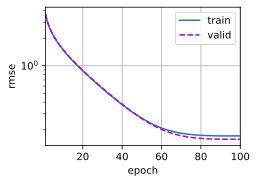

In [39]:
# 模型选择
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr, weight_decay, batch_size)
print(f'{k}-折验证：平均训练log rmse：{float(train_l):f},'
      f'平均验证lof rmse：{float(valid_l):f}')

In [40]:
# 提交kaggle预测
# 既然我们知道应该选择什么样的超参数，我们不妨使用所有数据对其进行训练
def train_and_pred(train_features, test_features, train_labels, test_data, num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None, num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch', ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
    print(f'训练log rmseL{float(train_ls[-1]):f}')
    # 将网络应用于测试机
    preds = net(test_features).detach().numpy()
    # 将其重新格式化以导出到kaggle
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)   # 将这两列拼接起来
    submission.to_csv('submission.csv', index=False)  # 不包含行索引，避免在文件中多出一列无意义的索引

训练log rmseL0.162313


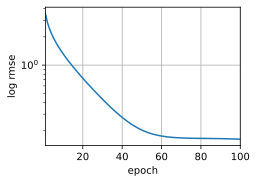

In [41]:
train_and_pred(train_features, test_features, train_labels, test_data, num_epochs, lr, weight_decay, batch_size)